In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [2]:
num_channels = 30 # EEG 채널 수
num_frames = 50 # 프레임 수 (시계열)
num_trials_per_class = 20 # class1,2에 대해 측정 횟수
m = 1

In [3]:
# ======= 가상 EEG 데이터 생성 =======
np.random.seed(42)

class_0 = np.random.randn(num_trials_per_class, num_channels, num_frames)
class_1 = np.random.randn(num_trials_per_class, num_channels, num_frames)
class_1[:, :5, :] *= 2.0  # 클래스 1의 앞쪽 채널 분산 증가

In [4]:
print("class0 크기(횟수, 채널, 프레임): " + str(class_0.shape))
print("class1 크기(횟수, 채널, 프레임): " + str(class_1.shape))

class0 크기(횟수, 채널, 프레임): (20, 30, 50)
class1 크기(횟수, 채널, 프레임): (20, 30, 50)


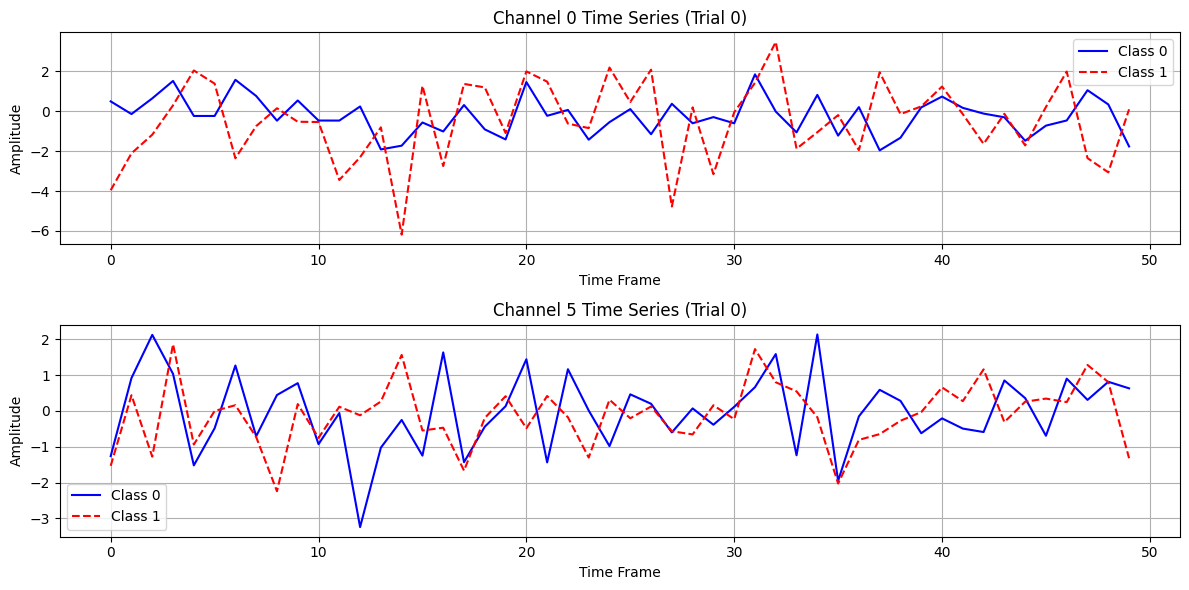

Channel 0 - Variance | Class 0: 0.854, Class 1: 3.881
Channel 5 - Variance | Class 0: 1.145, Class 1: 0.772


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 0과 클래스 1의 첫 번째 트라이얼
trial_0 = class_0[0]  # shape: (30, 50)
trial_1 = class_1[0]  # shape: (30, 50)

# 비교할 채널들: 0번(분산 강화된 채널), 5번(변경 없는 채널)
channels = [0, 5]

plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels):
    plt.subplot(2, 1, i + 1)
    plt.plot(trial_0[ch], label='Class 0', color='blue')
    plt.plot(trial_1[ch], label='Class 1', color='red', linestyle='--')
    plt.title(f'Channel {ch} Time Series (Trial 0)')
    plt.xlabel("Time Frame")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 분산 수치 출력
for ch in channels:
    var0 = np.var(trial_0[ch])
    var1 = np.var(trial_1[ch])
    print(f"Channel {ch} - Variance | Class 0: {var0:.3f}, Class 1: {var1:.3f}")

In [7]:
# ======= 공분산 계산 함수 =======
def compute_covariance(trials):
    covmats = []
    for trial in trials:
        trial = trial - np.mean(trial, axis=1, keepdims=True) # 각 채널의 중심을 0으로 옮김. 편향 제거. 수학적으로 분산 구할 때 x-mean 제곱의 합에서 평균 빼는 거랑 같은 원리
        cov = trial @ trial.T / trial.shape[1] # 공분산 공식 : 1/대각합 * (X)(X^전치)
        covmats.append(cov / np.trace(cov))
    return np.mean(covmats, axis=0) # trial에 대한 공분산을 평균 냄.

cov_0 = compute_covariance(class_0)
cov_1 = compute_covariance(class_1)

In [10]:
# 채널간의 분산을 알 수 있음
print(cov_0.shape)
print(cov_1.shape)

(30, 30)
(30, 30)


In [16]:
# ======= CSP 필터 계산 =======
eigvals, eigvecs = eigh(cov_0, cov_0 + cov_1) # 공식은 원래 class0과 class1의 분산을 최대로하는 고유값, 고유벡터를 찾지만,
# 이를 정규화 하는 개념으로 class0 +class1과 class0의 분산을 최대로하는 고유값과 고유벡터를 찾아도 됨.
# 공식은 동시 대각화를 통해 찾을 수 있음.
sorted_indices = np.argsort(eigvals)[::-1]
# 고유값들을 큰 값부터 순서대로 정렬했을 때, 해당 순서에 맞는 인덱스를 얻고 배열을 뒤집음
W = eigvecs[:, sorted_indices] # (30,30)
# W를 고유값이 높은 순으로 고유벡터를 배치함
W_csp = np.hstack([W[:, :m], W[:, -m:]])  # shape: (30, 2)
# 앞에서 m개 뒤에서 m개

(30, 30)


In [5]:
# ======= 모든 트라이얼에 대해 특징 추출 =======
def extract_features(trials, W_csp):
    features = []
    for trial in trials:
        Z = W_csp.T @ trial # W필터 x 원본데이터
        variances = np.var(Z, axis=1) # 행별 분산
        f = np.log(variances / np.sum(variances))  # shape: (2,)
        features.append(f)
    return np.array(features)  # shape: (num_trials, 2)

features_0 = extract_features(class_0, W_csp)
features_1 = extract_features(class_1, W_csp)


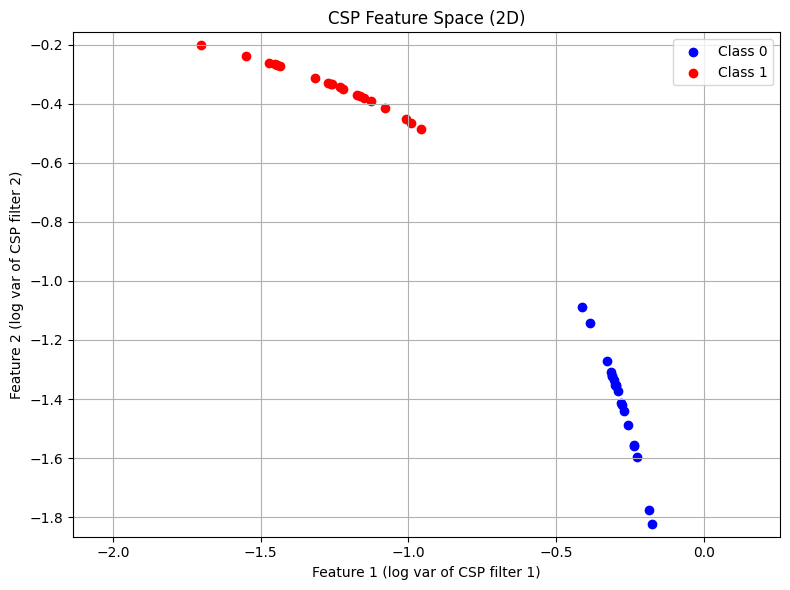

In [30]:
# ======= 시각화 =======
plt.figure(figsize=(8, 6))
plt.scatter(features_0[:, 0], features_0[:, 1], color='blue', label='Class 0')
plt.scatter(features_1[:, 0], features_1[:, 1], color='red', label='Class 1')
plt.title('CSP Feature Space (2D)')
plt.xlabel('Feature 1 (log var of CSP filter 1)')
plt.ylabel('Feature 2 (log var of CSP filter 2)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()